In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Activation
from keras.layers import Conv2D, MaxPooling2D,TimeDistributed, Concatenate
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import cv2
import os

In [2]:
# Load the numpy array

boxing = np.load('boxing.npy')
handclapping = np.load('handclapping.npy')
handwaving = np.load('handwaving.npy')

print("boxing shape: ", boxing.shape)
print("handclapping shape: ", handclapping.shape)
print("handwaving shape: ", handwaving.shape)

boxing shape:  (100, 20, 120, 160)
handclapping shape:  (99, 20, 120, 160)
handwaving shape:  (100, 20, 120, 160)


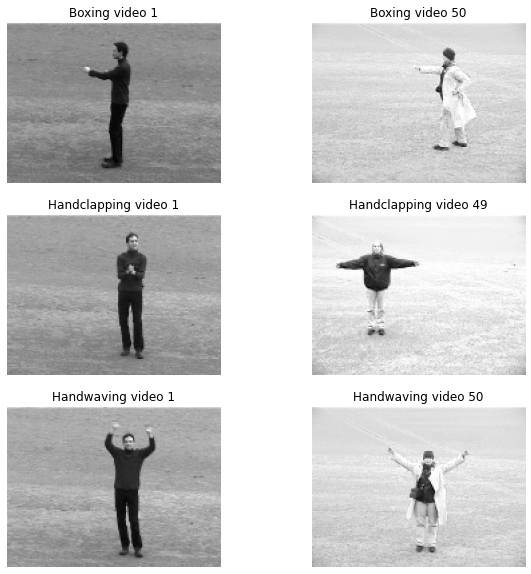

In [3]:
# Display 2 frames from a video clips from each class.
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(boxing[0][10], cmap='gray')
plt.title('Boxing video 1')
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(boxing[int(len(boxing)/2)][10], cmap='gray')
plt.title('Boxing video ' + str(int(len(boxing)/2)))
plt.axis('off')
plt.subplot(3, 2, 3)
plt.imshow(handclapping[0][10], cmap='gray')
plt.title('Handclapping video 1')
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(handclapping[int(len(handclapping)/2)][10], cmap='gray')
plt.title('Handclapping video ' + str(int(len(handclapping)/2)))
plt.axis('off')
plt.subplot(3, 2, 5)
plt.imshow(handwaving[0][10], cmap='gray')
plt.title('Handwaving video 1')
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(handwaving[int(len(handwaving)/2)][10], cmap='gray')
plt.title('Handwaving video ' + str(int(len(handwaving)/2)))
plt.axis('off')
plt.show()


In [4]:
# generate x-frame samples
def generate_x_frame_samples(data, frames_per_video):
    
    x_frame_samples = []
    for i in range(len(data)):
        for j in range(len(data[i]) - frames_per_video + 1):
            x_frame_samples.append(data[i][j:j+frames_per_video])
    return np.array(x_frame_samples)

In [5]:
nb_x_frames = 2

boxing_x_frame_samples = generate_x_frame_samples(boxing, nb_x_frames)
print("boxing_x_frame_samples shape: ", boxing_x_frame_samples.shape)

handclapping_x_frame_samples = generate_x_frame_samples(handclapping, nb_x_frames)
print("handclapping_x_frame_samples shape: ", handclapping_x_frame_samples.shape)

handwaving_x_frame_samples = generate_x_frame_samples(handwaving, nb_x_frames)
print("handwaving_x_frame_samples shape: ", handwaving_x_frame_samples.shape)

boxing_x_frame_samples shape:  (1900, 2, 120, 160)
handclapping_x_frame_samples shape:  (1881, 2, 120, 160)
handwaving_x_frame_samples shape:  (1900, 2, 120, 160)


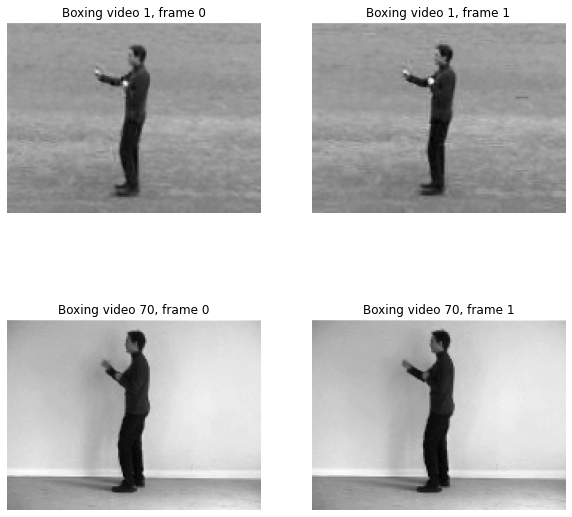

In [6]:
# Display the first 2 frames of the first 2 boxing_x_frame_samples
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(boxing_x_frame_samples[2][0], cmap='gray')
plt.title('Boxing video 1, frame 0')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(boxing_x_frame_samples[2][1], cmap='gray')
plt.title('Boxing video 1, frame 1')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(boxing_x_frame_samples[70][0], cmap='gray')
plt.title('Boxing video 70, frame 0')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(boxing_x_frame_samples[70][1], cmap='gray')
plt.title('Boxing video 70, frame 1')
plt.axis('off')
plt.show()

In [61]:
def split_train_test(data, train_test_ratio):
    train_size = int(len(data) * train_test_ratio)
    return data[:train_size], data[train_size:]

def create_train_test(boxing_x_frame_samples, handclapping_x_frame_samples, handwaving_x_frame_samples, train_test_ratio):
    train_boxing, test_boxing = split_train_test(boxing_x_frame_samples, train_test_ratio)
    train_handclapping, test_handclapping = split_train_test(handclapping_x_frame_samples, train_test_ratio)
    train_handwaving, test_handwaving = split_train_test(handwaving_x_frame_samples, train_test_ratio)

    X_train = np.concatenate((train_boxing, train_handclapping, train_handwaving))
    X_test = np.concatenate((test_boxing, test_handclapping, test_handwaving))

    y_train = np.array([0]*len(train_boxing) + [1]*len(train_handclapping) + [2]*len(train_handwaving))
    y_test = np.array([0]*len(test_boxing) + [1]*len(test_handclapping) + [2]*len(test_handwaving))

    # add an extra dimension for the grayscale channel
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1)

    # Shuffle the data
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]

    return X_train, X_test, y_train, y_test

train_test_ratio = 0.9


X_train, X_test, y_train, y_test = create_train_test(boxing_x_frame_samples, handclapping_x_frame_samples, handwaving_x_frame_samples, train_test_ratio)

print("\nX_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (5112, 2, 120, 160, 1)
X_test shape:  (569, 2, 120, 160, 1)
y_train shape:  (5112,)
y_test shape:  (569,)


In [62]:
optimizer_type = Adam(learning_rate=5e-5)  # optimisation algorithm: SGD stochastic gradient decent 
loss = 'categorical_crossentropy'  # loss (cost) function to be minimised by the optimiser
metrics = ['categorical_accuracy']  # network accuracy metric to be determined after each epoch
dropout_ratio = 0.5  # % of nodes in the hidden layer to dropout during back-propagation update of the network weights
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 30  # maxmimum number of epochs to be iterated
batch_size = 10   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch
num_hidden_nodes = 32 # number of nodes in hidden fully connected layer
num_back_nodes = 32

nb_classes = 3

In [79]:
# Create a deep learning model structure to categorize the videos into 3 classes, use advanced model architecture

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, TimeDistributed, BatchNormalization, Input

def create_model():
    input_shape = (2, 120, 160, 1)

    inputs = Input(shape=input_shape)

    # Add convolutional layers
    conv2d1 = TimeDistributed(Conv2D(filters=4, kernel_size=(3, 3), strides=(1, 1), padding='same'))(inputs)
    conv2d1 = TimeDistributed(Activation('relu'))(conv2d1)
    conv2d1 = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)))(conv2d1)

    print("cov2d1 shape : ", conv2d1.shape)
    # reduce overfitting with BatchNormalization
    conv2d1 = TimeDistributed(BatchNormalization())(conv2d1)

    conv2d2 = TimeDistributed(Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same'))(conv2d1)
    conv2d2 = TimeDistributed(Activation('relu'))(conv2d2)
    conv2d2 = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)))(conv2d2)

    print("cov2d2 shape : ", conv2d2.shape)

    conv3d1 = Conv3D(filters=4, kernel_size=(2, 3, 3), padding="same")(conv2d2)
    conv3d1 = Activation('relu')(conv3d1)
    conv3d1 = MaxPooling3D(pool_size=(1, 2, 2))(conv3d1)

    print("cov3d1 shape : ", conv3d1.shape)
    
    conv2d3 = TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu'))(conv3d1)
    conv2d3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv2d3)

    print("cov2d3 shape : ", conv2d3.shape)

    conv3d2 = Conv3D(16, kernel_size=(2, 2, 2), activation='relu')(conv2d3)
    conv3d2 = MaxPooling3D(pool_size=(1, 2, 2))(conv3d2)

    print("cov3d2 shape : ", conv3d2.shape)

    # Flatten the feature maps
    flatten = TimeDistributed(Flatten())(conv3d2)

    print("flatten shape : ", flatten.shape)

    # Add dense layers
    hidden1 = TimeDistributed(Dense(128, activation='relu'))(flatten)
    hidden1 = TimeDistributed(Dropout(0.5))(hidden1)
    hidden2 = TimeDistributed(Dense(32, activation='relu'))(hidden1)
    hidden2 = TimeDistributed(Dropout(0.3))(hidden2)

    print("hidden2 shape : ", hidden2.shape)

    output = Dense(3, activation='sigmoid')(hidden2)
    output = Flatten()(output)

    model = Model(inputs, output)

    return model



* Compiling the network model *

cov2d1 shape :  (None, 2, 60, 80, 4)
cov2d2 shape :  (None, 2, 30, 40, 8)
cov3d1 shape :  (None, 2, 15, 20, 4)
cov2d3 shape :  (None, 2, 6, 9, 64)
cov3d2 shape :  (None, 1, 2, 4, 16)
flatten shape :  (None, 1, 128)
hidden2 shape :  (None, 1, 32)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 120, 160, 1)]  0         
                                                                 
 time_distributed_156 (TimeD  (None, 2, 120, 160, 4)   40        
 istributed)                                                     
                                                                 
 time_distributed_157 (TimeD  (None, 2, 120, 160, 4)   0         
 istributed)                                                     
                                                                 
 time_distributed_158 (TimeD  (None, 2, 60, 8

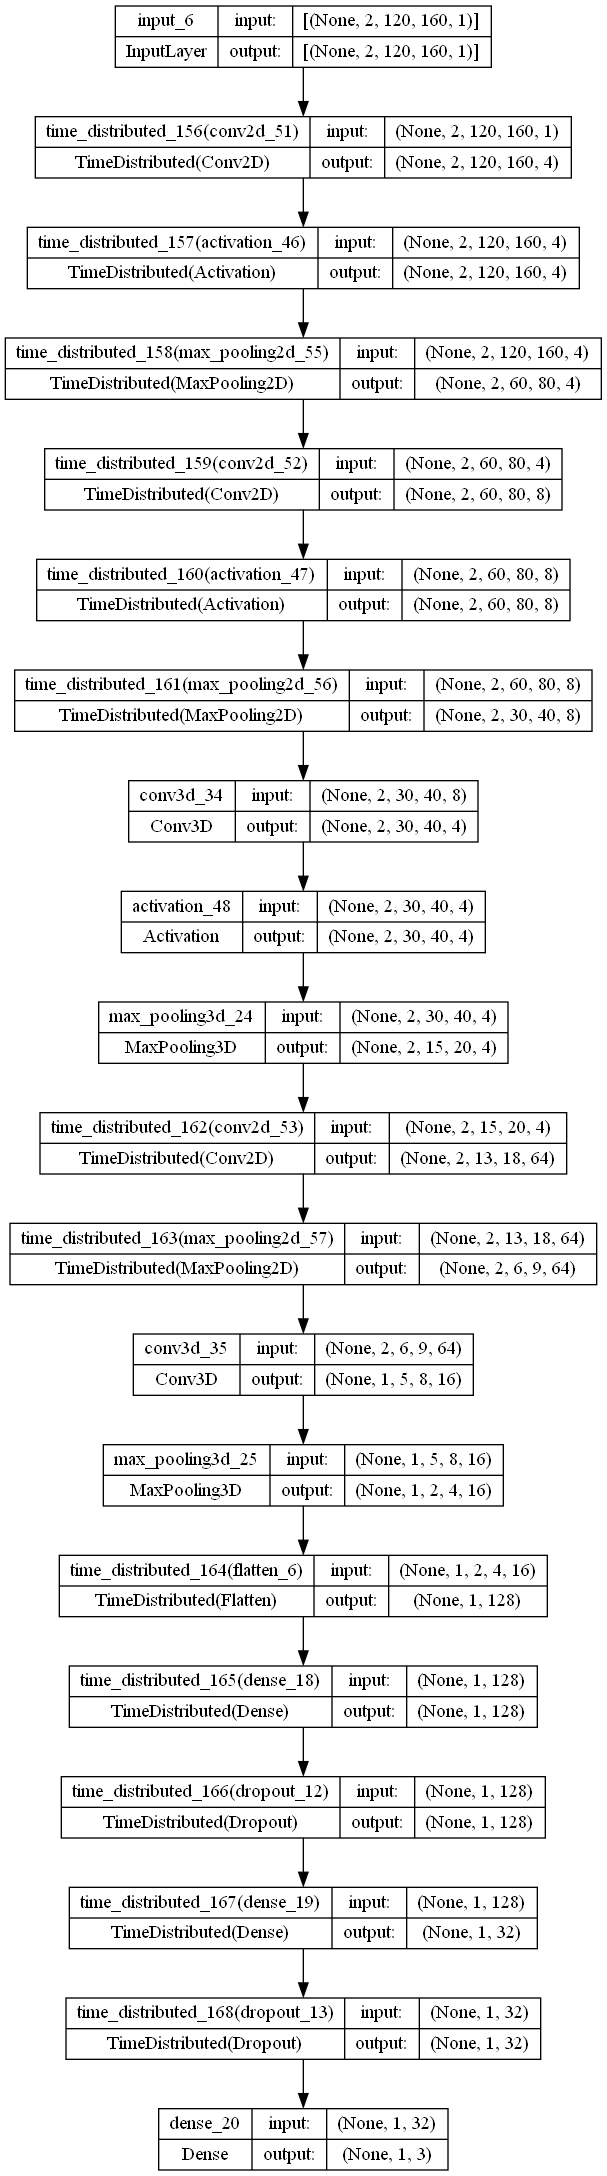

In [80]:
print()
print('* Compiling the network model *')
print()

model = create_model()  # create the model
model.compile(loss=loss, optimizer=optimizer_type, metrics=metrics)  # compile the model

# display a summary of the compiled neural network

print(model.summary())  
print()

# create and save a schematic image of the network architecture

from tensorflow.keras.utils import plot_model
from IPython.display import Image

print('Graphical schematic of the compiled network')
print()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')